# Light curve modelling - traditional 
- Extract flux points from each dataset
- Obtain the light curve
- model it using scipy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from gammapy.estimators import LightCurveEstimator, LightCurve
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.maps import MapAxis
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import (
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
)
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# Read the datasets previously produced
datasets = Datasets.read("./_datasets.yaml", "./_models.yaml")

## Define the Model

The actual flux will depend on the spectral shape assumed. For simplicity, we use the power law spectral model of index 3.4 used in the [reference paper](https://ui.adsabs.harvard.edu/abs/2009A%26A...502..749A/abstract).

In [3]:
spectral_model = PowerLawSpectralModel(
    index=3.4,
    amplitude=2e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(spectral_model=spectral_model, name="pks2155")

In [4]:
#Assign the same model to all datasets
for dataset in datasets:
    dataset.models = sky_model

## Extract the light curve

We first create the `~gammapy.time.LightCurveEstimator` for the list of datasets we just produced. We give the estimator the name of the source component to be fitted. This is useful if there are multiple components

In [5]:
lc_maker_1d = LightCurveEstimator(
    energy_range=[0.7, 20] * u.TeV, source="pks2155"
)

In [6]:
%%time
lc_1d = lc_maker_1d.run(datasets)

CPU times: user 6.89 s, sys: 47.8 ms, total: 6.94 s
Wall time: 6.98 s


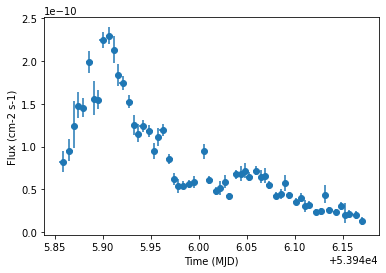

In [7]:
lc_1d.plot(marker="o")

## Model it using a sum of many Gaussian
- For simplicity, we model only 2 prominent features here

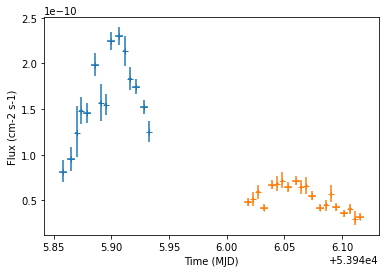

In [8]:
# Extract the two features to be modeled
lc_part1 = LightCurve(lc_1d.table[0:15])
lc_part1.plot()

lc_part2 = LightCurve(lc_1d.table[-30:-10])
lc_part2.plot()

In [9]:
x = np.append(lc_part1._get_times_and_errors()[0], lc_part2._get_times_and_errors()[0])
y = np.append(lc_part1.table["flux"].quantity.to_value('1/ (cm2 s)'), lc_part2.table["flux"].quantity.to_value('1/ (cm2 s)'))
yerr = np.append(lc_part1.table["flux_err"].quantity.to_value('1/ (cm2 s)'), lc_part2.table["flux_err"].quantity.to_value('1/ (cm2 s)'))

In [10]:
def gauss(x, A, tmean, tsig):
    return A*np.exp(-(x-tmean)**2/(2.0*tsig**2))

In [11]:
def lc(x, A1, m1, s1, A2, m2, s2):
    f1 = gauss(x, A1, m1, s1)
    f2 = gauss(x, A2, m2, s2)
    return (f1+f2)

In [12]:
popt, pcov = curve_fit(lc, x, y, sigma=yerr, p0=[1e-10, 53945.9, 0.01, 1e-11, 53946.08, 0.03])
print(popt)


[2.06715350e-10 5.39459030e+04 3.11009599e-02 6.23309807e-11
 5.39460549e+04 4.76338713e-02]


In [13]:
x1 = np.linspace(x[0] ,x[-1] ,100)
y1 = lc(x1, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])


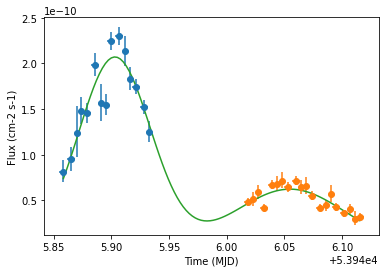

In [14]:
ax = lc_part1.plot(marker="o")
ax = lc_part2.plot(marker="o")
ax.plot(x1,y1)

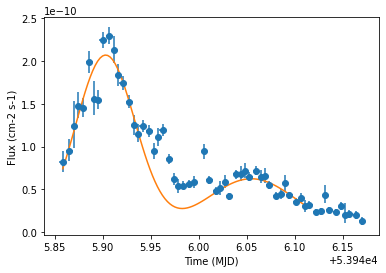

In [15]:
ax = lc_1d.plot(marker="o")
ax.plot(x1,y1)

We have modelled only 2 features - modelling the full light curve will probably need a combination of exponential rises and falls and many gaussians. Or, you can have some physically motivated model predicting fluxes that you can use here.